In [2]:
from model_trainer import *
from dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import normaltest, wilcoxon, ttest_ind

sns.set_theme(context="paper", style="white", palette="deep")
seed = 42

TRAIN_MODELS = False

/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_font_sizes(SMALL_SIZE=8, MEDIUM_SIZE=10, BIGGER_SIZE=12):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
scaler = 'minmax'
ds = {}
ds['A'] = Dataset('spinning_data.csv', scaler=scaler)
ds['B'] = Dataset('spinning_data_embeddings.csv', scaler=scaler)
#cv_type = 'kfold'
cv_type = 'groupkfold'
n_folds = 3
n_inner_folds = 5
mt = ModelTrainer(n_outer_folds=n_folds, n_inner_folds=n_inner_folds, cv_type=cv_type, random_state=seed)
models = {}
study_params = {
    'n_trails': 50,
    'timeout': 1800,
    'n_jobs': -1
}
targets = ds['A'].target_columns
targets_ordered = 'Strength (MPa)', 'Strain (mm/mm)', 'Toughness Modulus (MJ m-3)', 'Diameter (µm)', 'Youngs Modulus (GPa)'

/home/erik/Repositories/Spinning-condition-and-mechanical-properties/src/dataset.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 1.0, 1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0, 1.0, 1.0]
Length: 2190
Categories (2, float64): [1.0, 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self._df.loc[:, self.categorical_columns] = self._df.loc[:, self.categorical_columns].astype('category')
/home/erik/Repositories/Spinning-condition-and-mechanical-properties/src/dataset.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 1.0, 1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0, 1.0, 1.0]
Length: 2190
Categories (2, float64): [1.0, 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self._df.loc[:, self.categorical_columns] = self._df.loc[:, self.categorical_columns].ast

In [5]:
print(f'Number of rows: {len(ds['A'])}')
print(f'Number of columns: {len(ds['A'].columns)}')
print(f'Number of columns (PCA): {len(ds['B'].columns)}')
#print(ds['A'].df.loc[:,'Protein'].value_counts(normalize=True))
#print(ds['A'].df.loc[:,'Sample number'].value_counts(normalize=False).to_string())

Number of rows: 2190
Number of columns: 24
Number of columns (PCA): 39


In [6]:
if TRAIN_MODELS:
    for k in 'A', 'B':
        models[k] = {}
        for target in targets:
            model_params = mt.hyperparameter_search(ds[k], study_name=k, **study_params, target=target)
            models[k][target] = mt.train_model(ds[k], model_params, target=target)
            for i, model in enumerate(models[k][target]):
                save_model(model, f'../models/model_{k}_fold_{i}_{target.split()[0]}')

In [7]:
for k in 'A', 'B':
    models[k] = {}
    for target in targets:
        models[k][target] = [None] * n_folds
        for i in range(n_folds):
            models[k][target][i] = load_model(f'../models/model_{k}_fold_{i}_{target.split()[0]}')
            models[k][target][i].categorical_features = ds[k].categorical_columns

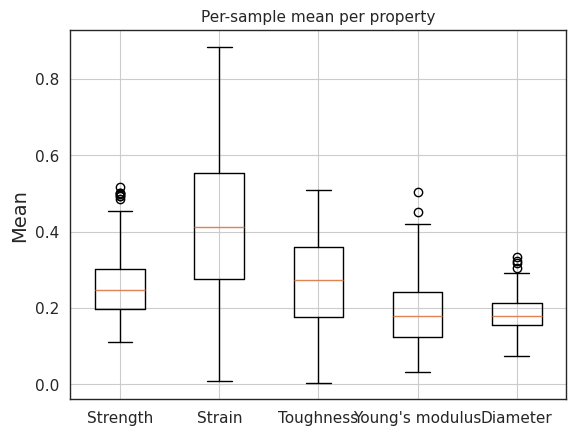

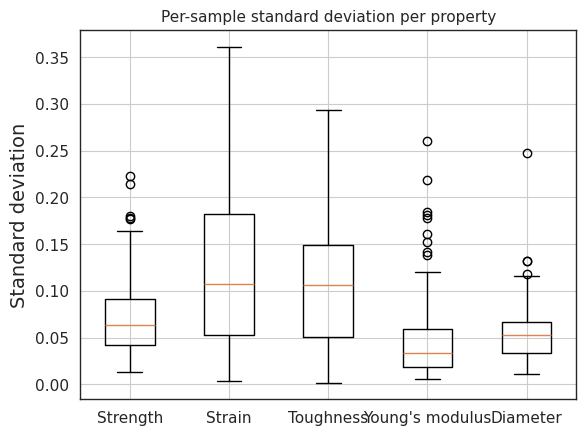

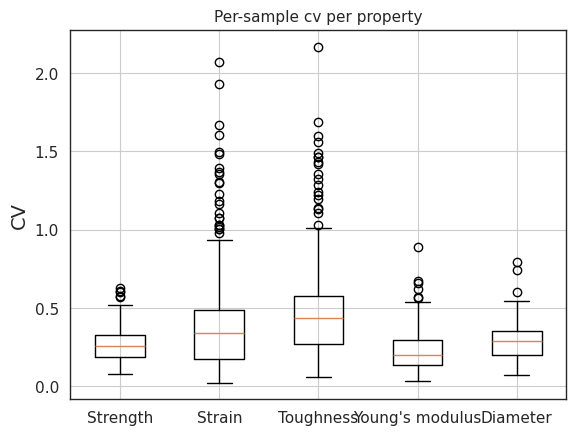

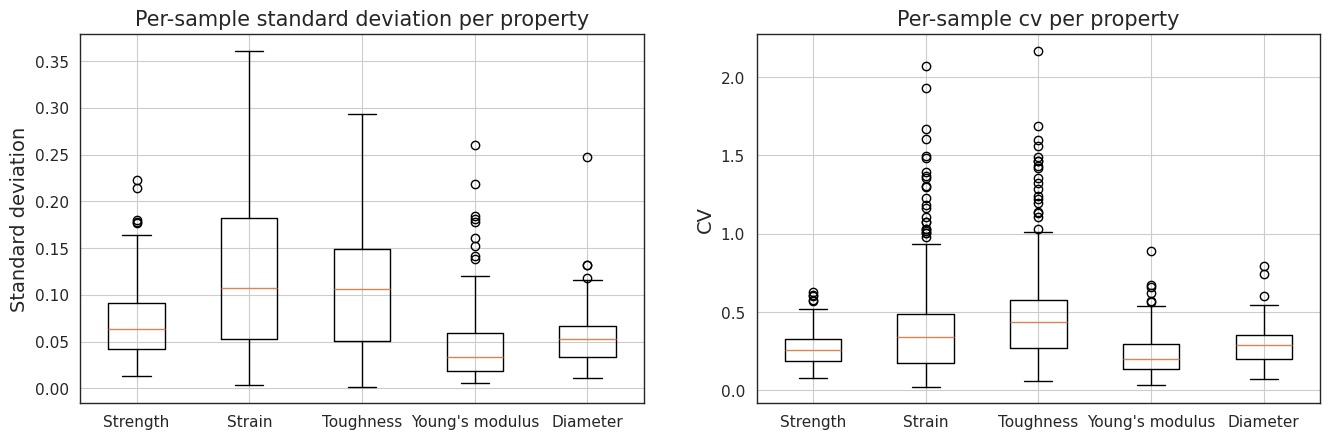

In [8]:
df_means = pd.DataFrame()
df_stds = pd.DataFrame()
df_cvs = pd.DataFrame()

df = ds['A'].group_samples()

for i in range(len(df)):
    if len(df.iloc[i, -1]) == 1: 
        continue
    sample = df.at[i, 'Sample number']
    df_means.at[i, 'Sample number'] = sample
    df_stds.at[i, 'Sample number'] = sample
    df_cvs.at[i, 'Sample number'] = sample
    for col in df.iloc[:, -5:].columns:
        df_means.at[i, col] = np.mean(df.at[i, col])
        df_stds.at[i, col] = np.std(df.at[i, col], ddof=1)
        df_cvs.at[i, col] = df_stds.at[i, col] / df_means.at[i, col]

target_names = 'Strength', 'Strain', 'Toughness', "Young's modulus", 'Diameter', 

set_font_sizes(11, 14, 20)

fig, ax = plt.subplots()
ax.boxplot(df_means.loc[:, targets_ordered], tick_labels=target_names)
ax.set_title("Per-sample mean per property")
ax.set_ylabel("Mean")
ax.grid(True)
plt.show()
fig.savefig('../figures/data_means')

fig, ax = plt.subplots()
ax.boxplot(df_stds.loc[:, targets_ordered], tick_labels=target_names)
ax.set_title("Per-sample standard deviation per property")
ax.set_ylabel("Standard deviation")
ax.grid(True)
plt.show()
fig.savefig('../figures/data_stds')

fig, ax = plt.subplots()
ax.boxplot(df_cvs.loc[:, targets_ordered], tick_labels=target_names)
ax.set_title("Per-sample cv per property")
ax.set_ylabel("CV")
ax.grid(True)
plt.show()
fig.savefig('../figures/data_cvs')

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(16)
'''
ax[0].boxplot(df_means.loc[:, targets_ordered], tick_labels=target_names)
ax[0].set_title("Per-sample mean per property", fontsize=15)
ax[0].set_ylabel("Mean")
ax[0].grid(True)
'''
ax[0].boxplot(df_stds.loc[:, targets_ordered], tick_labels=target_names)
ax[0].set_title("Per-sample standard deviation per property", fontsize=15)
ax[0].set_ylabel("Standard deviation")
ax[0].grid(True)
ax[1].boxplot(df_cvs.loc[:, targets_ordered], tick_labels=target_names)
ax[1].set_title("Per-sample cv per property", fontsize=15)
ax[1].set_ylabel("CV")
ax[1].grid(True)

plt.show()
fig.savefig('../figures/label_noise.png', bbox_inches='tight')

In [9]:
metrics = {}
metrics_tot = {}
metrics_mean = {}
metrics_std = {}

X = {}
X_tot = {}
Y_true = [None] * n_folds
Y_pred = {}
Y_pred_tot = {}
for k in 'A', 'B':
    X_, Y = ds[k]()
    X[k] = [None] * n_folds
    metrics[k] = [None] * n_folds
    Y_pred[k] = [None] * n_folds
    for fold, (train_idx, test_idx) in enumerate(mt._outer_cv.split(X_, groups=ds[k].sample_numbers.to_numpy())):
        X[k][fold] = X_.iloc[test_idx].copy()
        Y_true[fold] = Y.iloc[test_idx].copy()
        Y_pred[k][fold] = pd.DataFrame(columns=Y_true[fold].columns)
        for target in targets:
            Y_pred[k][fold].loc[:, target] = models[k][target][fold].predict(X_.iloc[test_idx].copy())
        Y_pred[k][fold] = Y_pred[k][fold].astype(float)
        metrics[k][fold] = compute_metrics(Y_true[fold], Y_pred[k][fold])
    X_tot[k] = pd.DataFrame(data=np.vstack(X[k]), columns=X_.columns)
    Y_true_tot = pd.DataFrame(data=np.vstack(Y_true), columns=Y.columns)
    Y_pred_tot[k] = pd.DataFrame(data=np.vstack(Y_pred[k]), columns=Y.columns)
    metrics_tot[k] = compute_metrics(Y_true_tot, Y_pred_tot[k])
    metrics_mean[k] = pd.DataFrame(np.array(metrics[k]).mean(axis=0), index=metrics[k][0].index, columns=metrics[k][0].columns)
    metrics_std[k] = pd.DataFrame(np.array(metrics[k]).std(axis=0, ddof=1), index=metrics[k][0].index, columns=metrics[k][0].columns)

In [10]:
np.vstack((metrics_tot['A'].iloc[:, 0].to_numpy(), metrics_tot['B'].iloc[:, 0].to_numpy(),
           metrics_tot['A'].iloc[:, 1].to_numpy(), metrics_tot['B'].iloc[:, 1].to_numpy()))

array([[0.07508447, 0.0501999 , 0.52490808, 0.72722742],
       [0.07500474, 0.05001636, 0.5259166 , 0.72934618],
       [0.21535701, 0.16043448, 0.32072214, 0.57772674],
       [0.21460491, 0.15979225, 0.32545842, 0.58104971]])

In [11]:
df_A = metrics_tot['A'].loc[:, targets_ordered]
df_B = metrics_tot['B'].loc[:, targets_ordered]
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
table = pd.DataFrame(index=target_names,
                     columns=['$A$', '$B$', '$A-B$', '$A$', '$B$', '$A-B$', '$A$', '$B$', '$A-B$', '$A$', '$B$', '$A-B$'],
                     data=np.vstack((df_A.iloc[0, :].to_numpy(), df_B.iloc[0, :].to_numpy(), df_A.iloc[0, :].to_numpy() - df_B.iloc[0, :].to_numpy(),
                                     df_A.iloc[1, :].to_numpy(), df_B.iloc[1, :].to_numpy(), df_A.iloc[1, :].to_numpy() - df_B.iloc[1, :].to_numpy(),
                                     df_A.iloc[2, :].to_numpy(), df_B.iloc[2, :].to_numpy(), df_A.iloc[2, :].to_numpy() - df_B.iloc[2, :].to_numpy(),
                                     df_A.iloc[3, :].to_numpy(), df_B.iloc[3, :].to_numpy(), df_A.iloc[3, :].to_numpy() - df_B.iloc[3, :].to_numpy())).T).map(lambda x: '{:.2E}'.format(x))

table

,$A$,$B$,$A-B$,$A$,$B$,$A-B$,$A$,$B$,$A-B$,$A$,$B$,$A-B$
Strength,9.93E-02,9.69E-02,2.43E-03,7.24E-02,6.99E-02,2.43E-03,2.41E-01,2.78E-01,-3.67E-02,5.18E-01,5.31E-01,-1.35E-02
Strain,2.15E-01,2.15E-01,7.52E-04,1.60E-01,1.60E-01,6.42E-04,3.21E-01,3.25E-01,-4.74E-03,5.78E-01,5.81E-01,-3.32E-03
Toughness,1.55E-01,1.56E-01,-1.08E-03,1.20E-01,1.20E-01,-6.77E-04,2.00E-01,1.89E-01,1.11E-02,4.58E-01,4.39E-01,1.86E-02
Diameter,7.51E-02,7.50E-02,7.97E-05,5.02E-02,5.00E-02,1.84E-04,5.25E-01,5.26E-01,-1.01E-03,7.27E-01,7.29E-01,-2.12E-03
Young's modulus,7.26E-02,7.26E-02,-2.06E-05,5.40E-02,5.34E-02,5.75E-04,9.66E-03,9.10E-03,5.63E-04,2.21E-01,2.27E-01,-5.32E-03


In [12]:
print(table.to_latex())

\begin{tabular}{lllllllllllll}
\toprule
 & $A$ & $B$ & $A-B$ & $A$ & $B$ & $A-B$ & $A$ & $B$ & $A-B$ & $A$ & $B$ & $A-B$ \\
\midrule
Strength & 9.93E-02 & 9.69E-02 & 2.43E-03 & 7.24E-02 & 6.99E-02 & 2.43E-03 & 2.41E-01 & 2.78E-01 & -3.67E-02 & 5.18E-01 & 5.31E-01 & -1.35E-02 \\
Strain & 2.15E-01 & 2.15E-01 & 7.52E-04 & 1.60E-01 & 1.60E-01 & 6.42E-04 & 3.21E-01 & 3.25E-01 & -4.74E-03 & 5.78E-01 & 5.81E-01 & -3.32E-03 \\
Toughness & 1.55E-01 & 1.56E-01 & -1.08E-03 & 1.20E-01 & 1.20E-01 & -6.77E-04 & 2.00E-01 & 1.89E-01 & 1.11E-02 & 4.58E-01 & 4.39E-01 & 1.86E-02 \\
Diameter & 7.51E-02 & 7.50E-02 & 7.97E-05 & 5.02E-02 & 5.00E-02 & 1.84E-04 & 5.25E-01 & 5.26E-01 & -1.01E-03 & 7.27E-01 & 7.29E-01 & -2.12E-03 \\
Young's modulus & 7.26E-02 & 7.26E-02 & -2.06E-05 & 5.40E-02 & 5.34E-02 & 5.75E-04 & 9.66E-03 & 9.10E-03 & 5.63E-04 & 2.21E-01 & 2.27E-01 & -5.32E-03 \\
\bottomrule
\end{tabular}



In [13]:
df_A = metrics_tot['A'].loc[:, targets_ordered]
df_B = metrics_tot['B'].loc[:, targets_ordered]
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
table = pd.DataFrame(index=target_names,
                     columns=['$A$', '$B$', '$A$', '$B$', '$A$', '$B$', '$A$', '$B$'],
                     data=np.vstack((df_A.iloc[0, :].to_numpy(), df_B.iloc[0, :].to_numpy(),
                                     df_A.iloc[1, :].to_numpy(), df_B.iloc[1, :].to_numpy(),
                                     df_A.iloc[2, :].to_numpy(), df_B.iloc[2, :].to_numpy(),
                                     df_A.iloc[3, :].to_numpy(), df_B.iloc[3, :].to_numpy())).T).map(lambda x: '{:.2E}'.format(x))
print(table.to_latex())

\begin{tabular}{lllllllll}
\toprule
 & $A$ & $B$ & $A$ & $B$ & $A$ & $B$ & $A$ & $B$ \\
\midrule
Strength & 9.93E-02 & 9.69E-02 & 7.24E-02 & 6.99E-02 & 2.41E-01 & 2.78E-01 & 5.18E-01 & 5.31E-01 \\
Strain & 2.15E-01 & 2.15E-01 & 1.60E-01 & 1.60E-01 & 3.21E-01 & 3.25E-01 & 5.78E-01 & 5.81E-01 \\
Toughness & 1.55E-01 & 1.56E-01 & 1.20E-01 & 1.20E-01 & 2.00E-01 & 1.89E-01 & 4.58E-01 & 4.39E-01 \\
Diameter & 7.51E-02 & 7.50E-02 & 5.02E-02 & 5.00E-02 & 5.25E-01 & 5.26E-01 & 7.27E-01 & 7.29E-01 \\
Young's modulus & 7.26E-02 & 7.26E-02 & 5.40E-02 & 5.34E-02 & 9.66E-03 & 9.10E-03 & 2.21E-01 & 2.27E-01 \\
\bottomrule
\end{tabular}



In [14]:
metrics_tot['A'].iloc[:, 0]

RMSE     0.075084
MAE      0.050200
$R^2$    0.524908
PCC      0.727227
Name: Diameter (µm), dtype: float64

In [15]:
metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.075084,0.215357,0.099283,0.072560,0.155037
MAE,0.050200,0.160434,0.072363,0.054006,0.119719
$R^2$,0.524908,0.320722,0.241150,0.009659,0.199654
PCC,0.727227,0.577727,0.517945,0.221258,0.457563


In [16]:
metrics_tot['B']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.075005,0.214605,0.096852,0.072581,0.156114
MAE,0.050016,0.159792,0.069928,0.053431,0.120396
$R^2$,0.525917,0.325458,0.277846,0.009096,0.188505
PCC,0.729346,0.581050,0.531451,0.226583,0.438982


In [17]:
metrics_tot['B'] - metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,-0.000080,-0.000752,-0.002430,0.000021,0.001076
MAE,-0.000184,-0.000642,-0.002435,-0.000575,0.000677
$R^2$,0.001009,0.004736,0.036696,-0.000563,-0.011149
PCC,0.002119,0.003323,0.013506,0.005325,-0.018582


In [18]:
100 * (metrics_tot['B'] - metrics_tot['A']) / metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,-0.106196,-0.349236,-2.447833,0.028401,0.694075
MAE,-0.365607,-0.400307,-3.364326,-1.064609,0.565310
$R^2$,0.192133,1.476755,15.217119,-5.824769,-5.583952
PCC,0.291347,0.575181,2.607603,2.406589,-4.061003


In [19]:
print(metrics_mean['A'].to_latex())
print(metrics_mean['B'].to_latex())
print((metrics_mean['B'] - metrics_mean['A']).to_latex())
print((100 * (metrics_mean['B'] - metrics_mean['A']) / metrics_mean['A']).to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Diameter (µm) & Strain (mm/mm) & Strength (MPa) & Youngs Modulus (GPa) & Toughness Modulus (MJ m-3) \\
\midrule
RMSE & 0.074959 & 0.215089 & 0.099203 & 0.072465 & 0.154950 \\
MAE & 0.050239 & 0.160368 & 0.072424 & 0.054010 & 0.119649 \\
$R^2$ & 0.518983 & 0.318741 & 0.232590 & -0.002950 & 0.199435 \\
PCC & 0.725932 & 0.579250 & 0.508510 & 0.234203 & 0.460878 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
 & Diameter (µm) & Strain (mm/mm) & Strength (MPa) & Youngs Modulus (GPa) & Toughness Modulus (MJ m-3) \\
\midrule
RMSE & 0.074858 & 0.214319 & 0.096860 & 0.072527 & 0.156030 \\
MAE & 0.050076 & 0.159726 & 0.069993 & 0.053455 & 0.120314 \\
$R^2$ & 0.520757 & 0.323558 & 0.266600 & -0.002401 & 0.188249 \\
PCC & 0.729573 & 0.582224 & 0.520807 & 0.233999 & 0.441964 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
 & Diameter (µm) & Strain (mm/mm) & Strength (MPa) & Youngs Modulus (GPa) & Toughness Modulus (MJ m-3) \\
\midrul

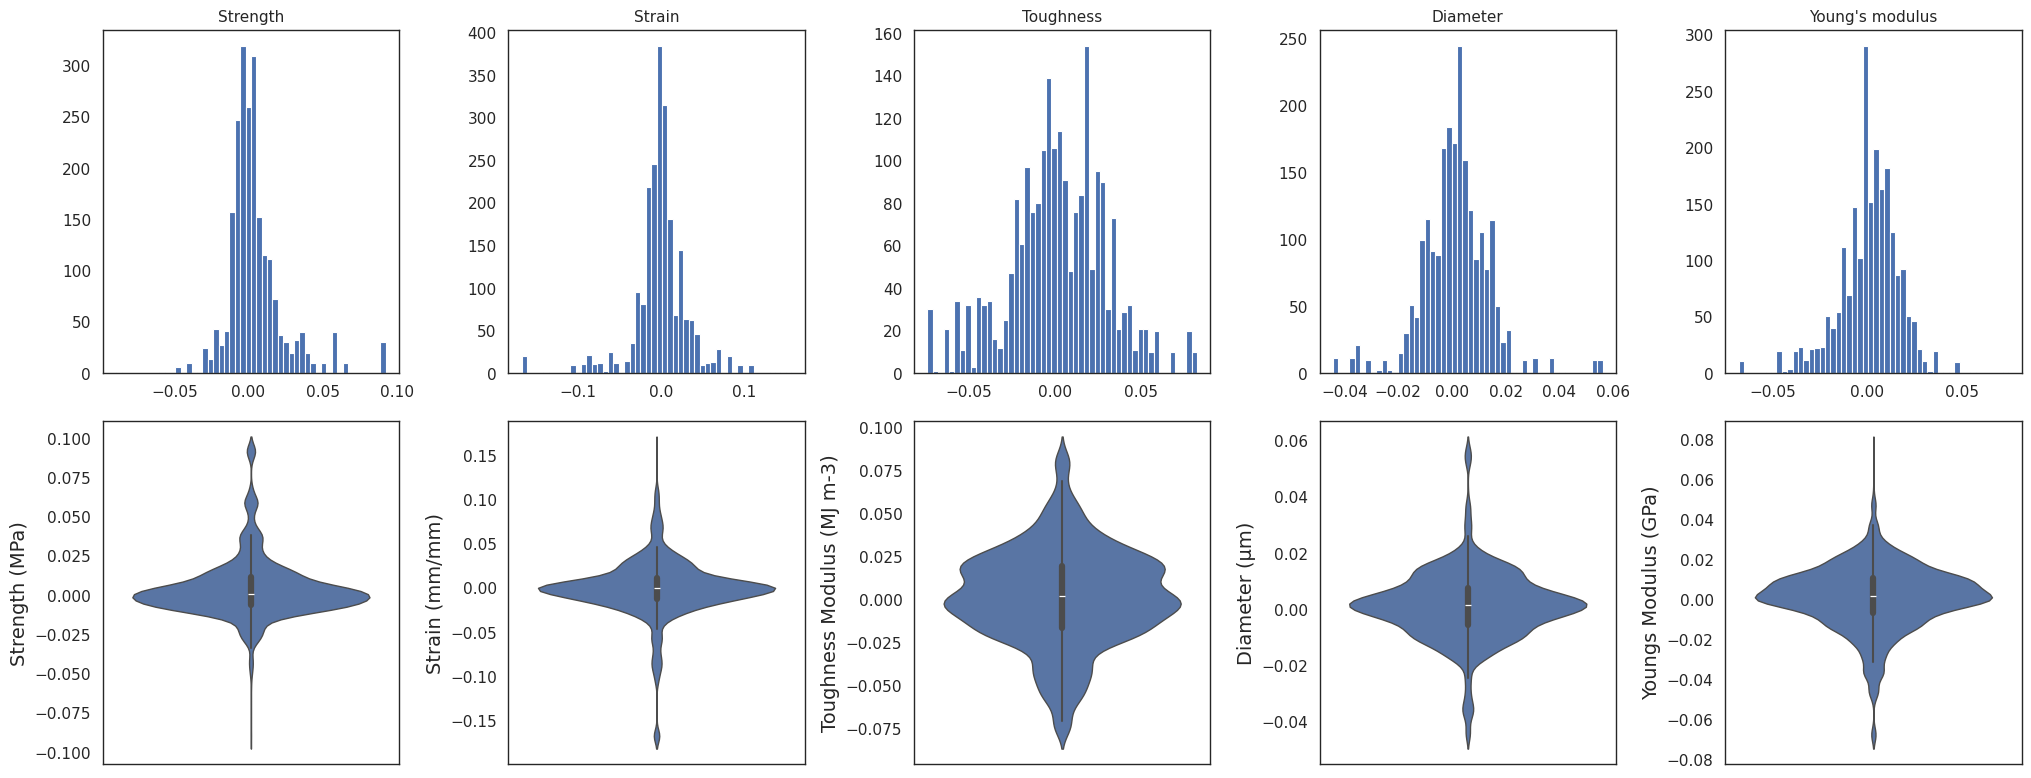

NormaltestResult(statistic=array([793.11129863, 529.67769761,   8.88294382, 199.93330506,
       250.63751168]), pvalue=array([5.99887393e-173, 9.59288790e-116, 1.17785887e-002, 3.84622275e-044,
       3.75626186e-055]))
TtestResult(statistic=array([ 2.0823064 , -0.1095285 ,  0.53075991,  0.48574911,  0.85259414]), pvalue=array([0.03737242, 0.91278834, 0.59561209, 0.62716937, 0.39393105]), df=array([4378., 4378., 4378., 4378., 4378.]))
<bound method TtestResult.confidence_interval of TtestResult(statistic=array([ 2.0823064 , -0.1095285 ,  0.53075991,  0.48574911,  0.85259414]), pvalue=array([0.03737242, 0.91278834, 0.59561209, 0.62716937, 0.39393105]), df=array([4378., 4378., 4378., 4378., 4378.]))>
WilcoxonResult(statistic=array([1004196., 1192343., 1106726., 1026749., 1043771.]), pvalue=array([4.06725895e-11, 8.07014965e-01, 1.70566816e-03, 5.23390785e-09,
       1.40645210e-07]))


In [20]:
fig, ax = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(8)
plt.tight_layout(w_pad=4, h_pad=1)
diff = Y_pred_tot['A'].loc[:, targets_ordered] - Y_pred_tot['B'].loc[:, targets_ordered]
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
for i, target in enumerate(target_names):
    ax[0][i].set_title(target)
    ax[0][i].hist(diff.iloc[:, i], bins=50)
    sns.violinplot(ax=ax[1][i], data=diff.iloc[:, i], bw_method='scott')
plt.show()
print(normaltest(diff))

result = ttest_ind(Y_pred_tot['A'].loc[:, targets_ordered], Y_pred_tot['B'].loc[:, targets_ordered])
print(result)
print(result.confidence_interval)

print(wilcoxon(Y_pred_tot['A'].loc[:, targets_ordered], Y_pred_tot['B'].loc[:, targets_ordered]))

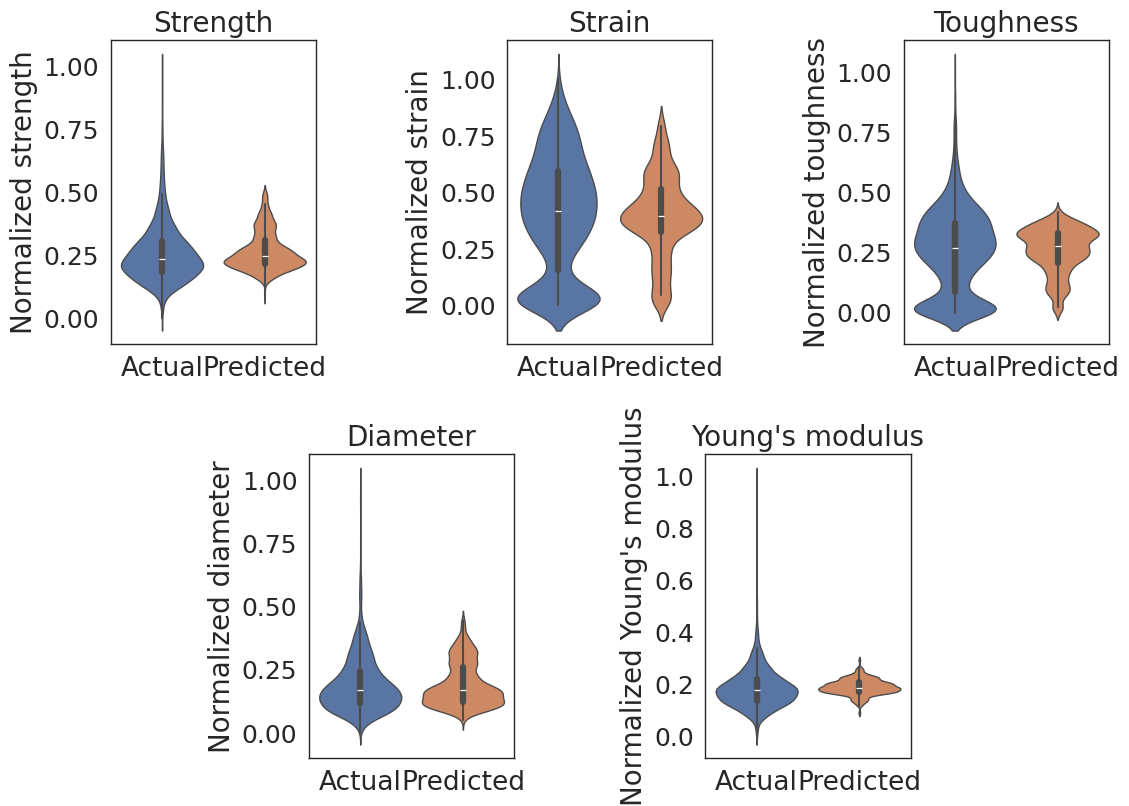

In [33]:
orientation = 'horizontal'
palettes = [None, ['g', 'm']]

if orientation == 'vertical':
    fig = plt.figure(figsize=(8,11))
    ax = [plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2),
        plt.subplot2grid((3,4), (0,2), colspan=2),
        plt.subplot2grid((3,4), (1,0), colspan=2),
        plt.subplot2grid((3,4), (1,2), colspan=2),
        plt.subplot2grid((3,4), (2,1), colspan=2)]
else:
    fig = plt.figure(figsize=(11,8))
    ax = [plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2),
        plt.subplot2grid((2,6), (0,2), colspan=2),
        plt.subplot2grid((2,6), (0,4), colspan=2),
        plt.subplot2grid((2,6), (1,1), colspan=2),
        plt.subplot2grid((2,6), (1,3), colspan=2)]

#set_font_sizes(12, 18)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.tight_layout(w_pad=8, h_pad=4)
k = 'A'
target_names = 'strength', 'strain', 'toughness', 'diameter', "Young's modulus"
for i, target in enumerate(targets_ordered):
    df = pd.DataFrame(data=np.vstack((Y_true_tot.loc[:, target].to_numpy(), Y_pred_tot[k].loc[:, target].to_numpy())).T,\
        columns=('Actual', 'Predicted'))
    ax[i].set_ylabel(f'Normalized {target_names[i]}')
    ax[i].set_title((lambda s: s[0].upper() + s[1:])(target_names[i]), fontsize=20)
    ax[i].xaxis.set_tick_params(labelsize=19)
    ax[i].yaxis.set_tick_params(labelsize=18)
    ax[i].yaxis.label.set_fontsize(20)
    sns.violinplot(ax=ax[i], data=df, bw_method='scott', palette=palettes[0])

fig.savefig(f'../figures/distribution.png', bbox_inches='tight')
plt.show()

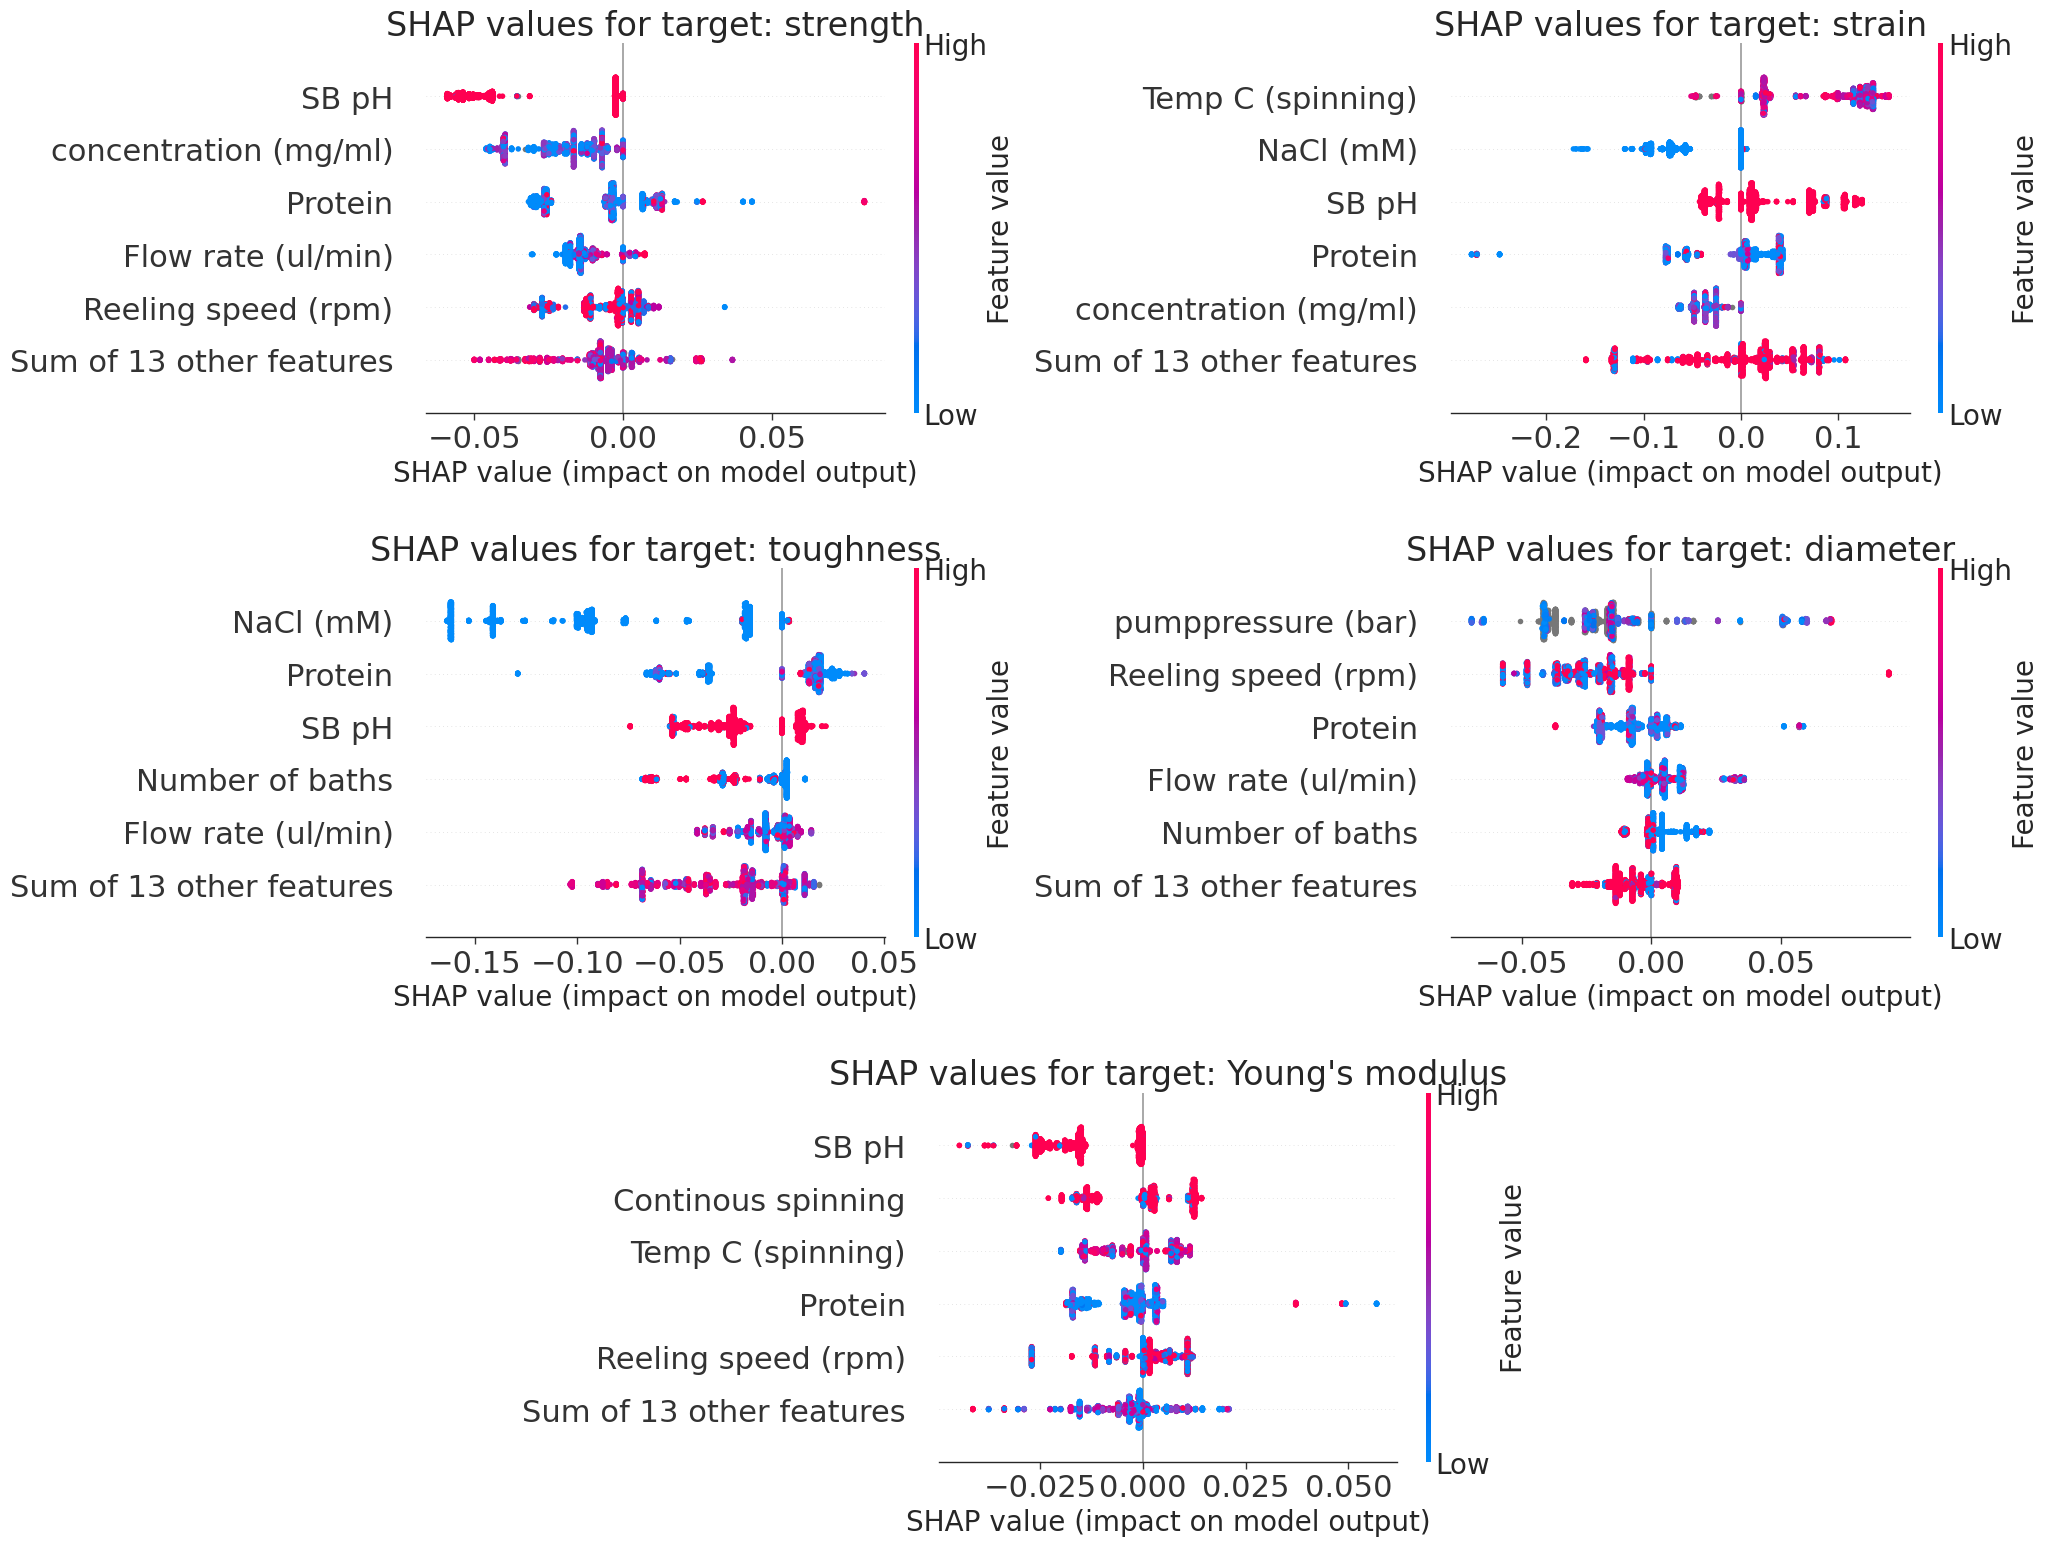

[<Axes: title={'center': 'SHAP values for target: strength'}, xlabel='SHAP value (impact on model output)'>, <Axes: title={'center': 'SHAP values for target: strain'}, xlabel='SHAP value (impact on model output)'>, <Axes: title={'center': 'SHAP values for target: toughness'}, xlabel='SHAP value (impact on model output)'>, <Axes: title={'center': 'SHAP values for target: diameter'}, xlabel='SHAP value (impact on model output)'>, <Axes: title={'center': "SHAP values for target: Young's modulus"}, xlabel='SHAP value (impact on model output)'>, <Axes: label='<colorbar>', ylabel='Feature value'>, <Axes: label='<colorbar>', ylabel='Feature value'>, <Axes: label='<colorbar>', ylabel='Feature value'>, <Axes: label='<colorbar>', ylabel='Feature value'>, <Axes: label='<colorbar>', ylabel='Feature value'>]


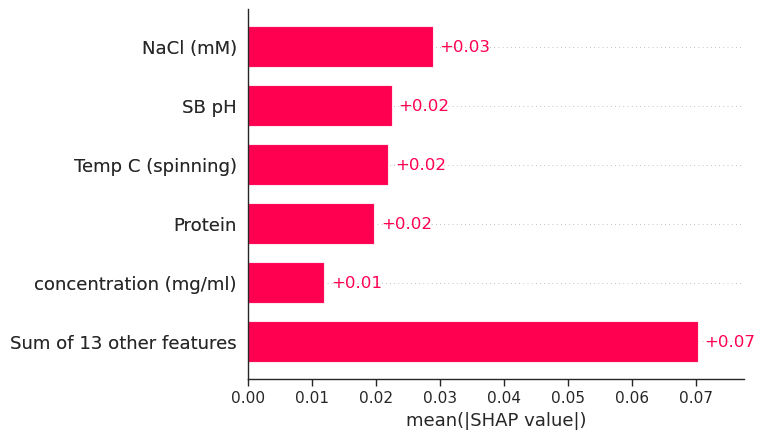

In [22]:
format=True
if format:
    fig = plt.figure(figsize=(17,15))
    ax = [plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2),
        plt.subplot2grid((3,4), (0,2), colspan=2),
        plt.subplot2grid((3,4), (1,0), colspan=2),
        plt.subplot2grid((3,4), (1,2), colspan=2),
        plt.subplot2grid((3,4), (2,1), colspan=2)]
    fig.tight_layout(w_pad=25, h_pad=7)
else:
    fig, ax = plt.subplots(5,1)
    fig.set_figheight(25)

k = 'A'
max_display=6

X_encoded = [pd.DataFrame()] * n_folds
X_encoded_tot = X_tot[k].copy()
for fold in range(n_folds):
    X_encoded[fold] = X[k][fold].copy() 
    for col in ds[k].categorical_columns:  
        X_encoded[fold][col] = X_encoded[fold][col].astype("category")
        X_encoded[fold][col] = X_encoded[fold][col].cat.codes  # convert to integer codes
    for col in ds[k].numerical_columns:  
        X_encoded[fold][col] = X_encoded[fold][col].astype("float64")
for col in ds[k].categorical_columns:  
    X_encoded_tot[col] = X_encoded_tot[col].astype("category")
    X_encoded_tot[col] = X_encoded_tot[col].cat.codes  # convert to integer codes

target_names = 'strength', 'strain', 'toughness', 'diameter', "Young's modulus"
features = X_encoded_tot.to_numpy().astype('float64')
base_values = X_encoded_tot.to_numpy().mean(axis=0)

shap_values_avg = np.zeros(X_encoded_tot.shape)
# Loop over each target output
K = 5
top_features_tot_inds = set()
top_features = []
for i, target in enumerate(targets_ordered):
    shap_values = np.zeros(X_encoded_tot.shape)
    for fold in range(n_folds):
        # Compute SHAP values for the input data
        explainer = shap.Explainer(models[k][targets_ordered[i]][fold])
        shap_values[fold*X_encoded[fold].shape[0] : (fold+1)*X_encoded[fold].shape[0]] = explainer(X_encoded[fold]).values
    shap_values_avg += np.abs(shap_values)

    top_inds = np.abs(shap_values).mean(axis=0).argsort()[-K:][::-1]
    top_features_tot_inds.update(top_inds)
    top_features.append(list(X_encoded_tot.columns[top_inds]))
    explanation = shap.Explanation(shap_values, feature_names=X_encoded_tot.columns, data=features, base_values=base_values)
    # Plot summary plot
    color_bar = True#i in [1,3,4]
    shap.plots.beeswarm(explanation, max_display=max_display, ax=ax[i], plot_size=None, show=False, color_bar=color_bar)
    ax[i].set_title(f"SHAP values for target: {target_names[i]}", fontsize=24)
    ax[i].xaxis.set_tick_params(labelsize=22)
    ax[i].yaxis.set_tick_params(labelsize=22)
    ax[i].xaxis.label.set_fontsize(20)
    cbar = fig.axes[-1]
    cbar.tick_params(labelsize=20)
    cbar.set_ylabel('Feature value', fontsize=20)
plt.show()
fig.savefig('../figures/SHAP.png', bbox_inches='tight')
print(fig.axes)

top_features_tot_inds = list(top_features_tot_inds)
top_features_tot = list(X_encoded_tot.columns[top_features_tot_inds])

shap_values_avg /= 5
fig, ax = plt.subplots()
explanation = shap.Explanation(shap_values_avg, feature_names=X_encoded_tot.columns, data=features, base_values=base_values)
shap.plots.bar(explanation, ax=ax, max_display=max_display, show=False)
plt.show()
fig.savefig('../figures/SHAP_bar.png')

In [23]:
print(top_features_tot)

['Protein', 'concentration (mg/ml)', 'Number of baths', 'SB pH', 'NaCl (mM)', 'Reeling speed (rpm)', 'Flow rate (ul/min)', 'pumppressure (bar)', 'Temp C (spinning)', 'Continous spinning']


In [24]:
print(top_features)

[['SB pH', 'concentration (mg/ml)', 'Protein', 'Flow rate (ul/min)', 'Reeling speed (rpm)'], ['Temp C (spinning)', 'NaCl (mM)', 'SB pH', 'Protein', 'concentration (mg/ml)'], ['NaCl (mM)', 'Protein', 'SB pH', 'Number of baths', 'Flow rate (ul/min)'], ['pumppressure (bar)', 'Reeling speed (rpm)', 'Protein', 'Flow rate (ul/min)', 'Number of baths'], ['SB pH', 'Continous spinning', 'Temp C (spinning)', 'Protein', 'Reeling speed (rpm)']]


In [25]:
# Top K features selected from SHAP ranking
#K = 10
#top_features_inds = shap_values_avg.mean(axis=0).argsort()[-K:][::-1]
#top_features = list(X_encoded_tot.columns[top_features_inds])

#ds_ablation = {target: Dataset(ds[k].df.loc[:, ['Sample number'] + top_features[i] + ds[k].target_columns], scaler=scaler) for i, target in enumerate(targets)}
ds_ablation = {target: Dataset(ds[k].df.loc[:, ['Sample number'] + top_features_tot + ds[k].target_columns], scaler=scaler) for i, target in enumerate(targets)}
params = {target: [model.get_params() for model in models[k][target]] for target in targets}
models_ablation = {target: mt.train_model(ds_ablation[target], params[target], target=target) for target in targets}


In [26]:
metrics_ablation = [None] * n_folds
Y_ablation_pred = [pd.DataFrame(columns=targets) for _ in range(n_folds)]
#Y_ablation_true = [None] * n_folds
for target in targets:
    X_, Y = ds_ablation[target]()
    print(X_.columns)
    for fold, (train_idx, test_idx) in enumerate(mt._outer_cv.split(X_, groups=ds['A'].sample_numbers)):
        Y_ablation_pred[fold].loc[:, target] = models_ablation[target][fold].predict(X_.iloc[test_idx].copy())
        #Y_ablation_true[fold].loc[:, target] = Y.loc[test_idx, target]

for fold in 0,1,2:
    Y_ablation_pred[fold] = Y_ablation_pred[fold].astype(float)
    metrics_ablation[fold] = compute_metrics(Y_true[fold], Y_ablation_pred[fold])
Y_ablation_pred_tot = pd.DataFrame(data=np.vstack(Y_ablation_pred), columns=Y.columns)
metrics_ablation_tot = compute_metrics(Y_true_tot, Y_ablation_pred_tot)
metrics_ablation_mean = pd.DataFrame(np.array(metrics_ablation).mean(axis=0), index=metrics_ablation[0].index, columns=metrics_ablation[0].columns)
metrics_ablation_std = pd.DataFrame(np.array(metrics_ablation).std(axis=0, ddof=1), index=metrics_ablation[0].index, columns=metrics_ablation[0].columns)

Index(['Protein', 'concentration (mg/ml)', 'Number of baths', 'SB pH',
       'NaCl (mM)', 'Reeling speed (rpm)', 'Flow rate (ul/min)',
       'pumppressure (bar)', 'Temp C (spinning)', 'Continous spinning'],
      dtype='object')
Index(['Protein', 'concentration (mg/ml)', 'Number of baths', 'SB pH',
       'NaCl (mM)', 'Reeling speed (rpm)', 'Flow rate (ul/min)',
       'pumppressure (bar)', 'Temp C (spinning)', 'Continous spinning'],
      dtype='object')
Index(['Protein', 'concentration (mg/ml)', 'Number of baths', 'SB pH',
       'NaCl (mM)', 'Reeling speed (rpm)', 'Flow rate (ul/min)',
       'pumppressure (bar)', 'Temp C (spinning)', 'Continous spinning'],
      dtype='object')
Index(['Protein', 'concentration (mg/ml)', 'Number of baths', 'SB pH',
       'NaCl (mM)', 'Reeling speed (rpm)', 'Flow rate (ul/min)',
       'pumppressure (bar)', 'Temp C (spinning)', 'Continous spinning'],
      dtype='object')
Index(['Protein', 'concentration (mg/ml)', 'Number of baths', 'SB pH',
     

In [27]:
metrics_ablation_tot

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.077970,0.229732,0.097725,0.073723,0.155999
MAE,0.052965,0.167769,0.072946,0.055077,0.121000
$R^2$,0.487696,0.227013,0.264778,-0.022327,0.189695
PCC,0.704693,0.510658,0.537583,0.184412,0.448535


In [28]:
metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.075084,0.215357,0.099283,0.072560,0.155037
MAE,0.050200,0.160434,0.072363,0.054006,0.119719
$R^2$,0.524908,0.320722,0.241150,0.009659,0.199654
PCC,0.727227,0.577727,0.517945,0.221258,0.457563


In [29]:
metrics_ablation_tot / metrics_tot['A']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,1.038425,1.066749,0.984309,1.016021,1.006202
MAE,1.055082,1.045718,1.008063,1.019833,1.010696
$R^2$,0.929107,0.707819,1.097979,-2.311518,0.950119
PCC,0.969013,0.883910,1.037915,0.833470,0.980269


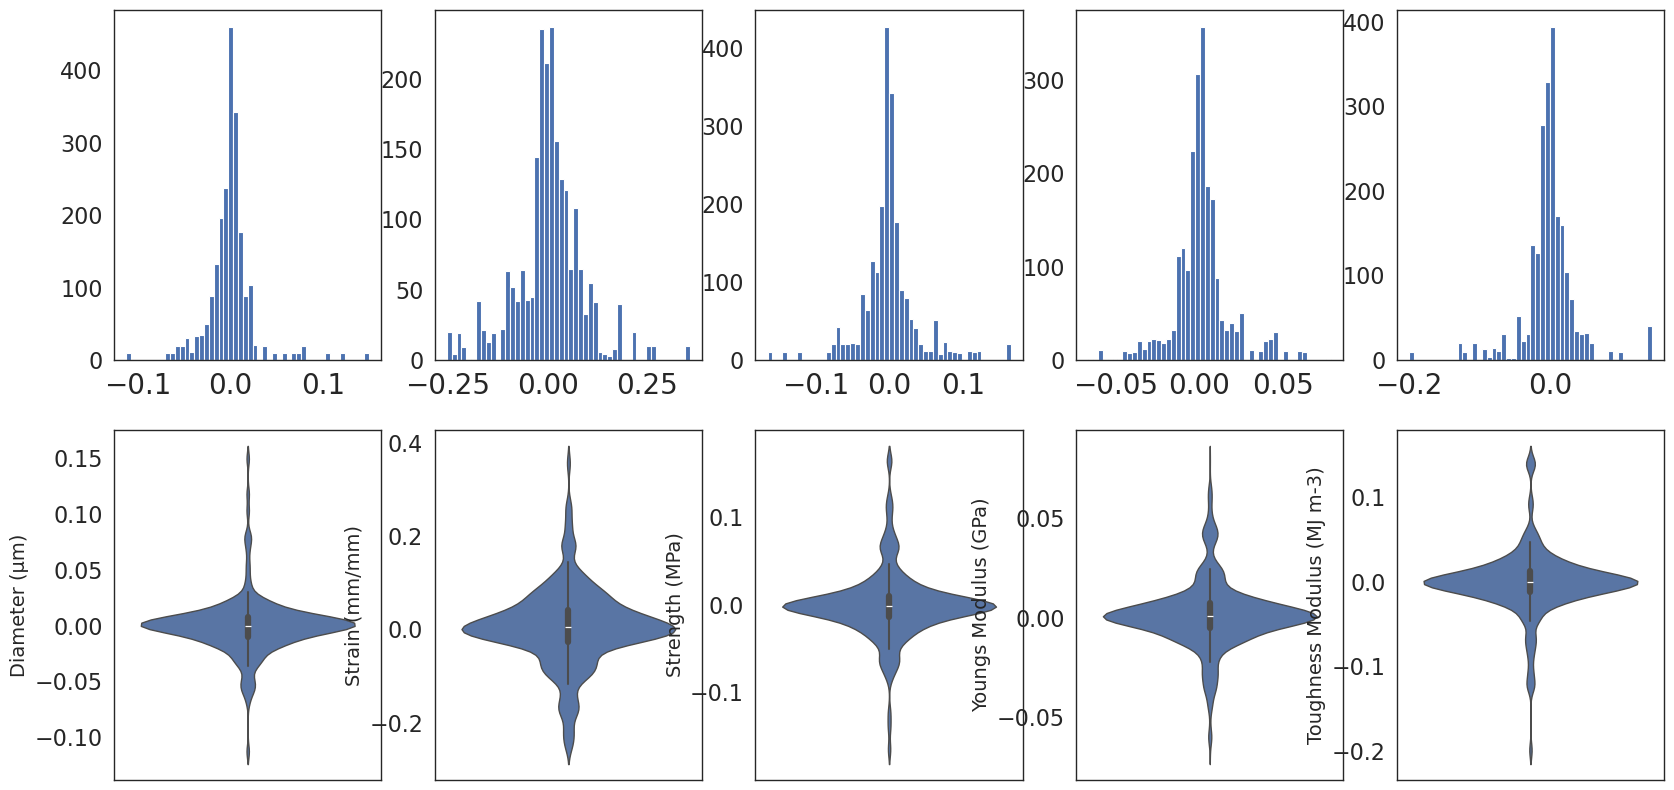

NormaltestResult(statistic=array([701.59707825, 125.34162294, 301.78638169, 214.8851732 ,
       337.11527287]), pvalue=array([4.46817526e-153, 6.05915973e-028, 2.93710762e-066, 2.17910179e-047,
       6.25674729e-074]))
TtestResult(statistic=array([-0.12969754,  0.82874225, -0.11821531,  1.43204382, -0.41260978]), pvalue=array([0.89681169, 0.40729545, 0.90590248, 0.15220267, 0.67991274]), df=array([4378., 4378., 4378., 4378., 4378.]))
WilcoxonResult(statistic=array([1136144., 1084755., 1093475., 1105202., 1175905.]), pvalue=array([3.20974183e-02, 1.04634237e-04, 3.37148562e-04, 1.42913520e-03,
       4.23881760e-01]))


In [30]:
fig, ax = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(10)
diff = Y_pred_tot['A'] - Y_ablation_pred_tot
for i in range(5):
    ax[0][i].hist(diff.iloc[:, i], bins=50)
    sns.violinplot(ax=ax[1][i], data=diff.iloc[:, i], bw_method='scott')
plt.show()
print(normaltest(Y_pred_tot['A'] - Y_ablation_pred_tot))

result = ttest_ind(Y_pred_tot['A'], Y_ablation_pred_tot)
print(result)

print(wilcoxon(Y_pred_tot['A'], Y_ablation_pred_tot))

KeyError: 'R2'

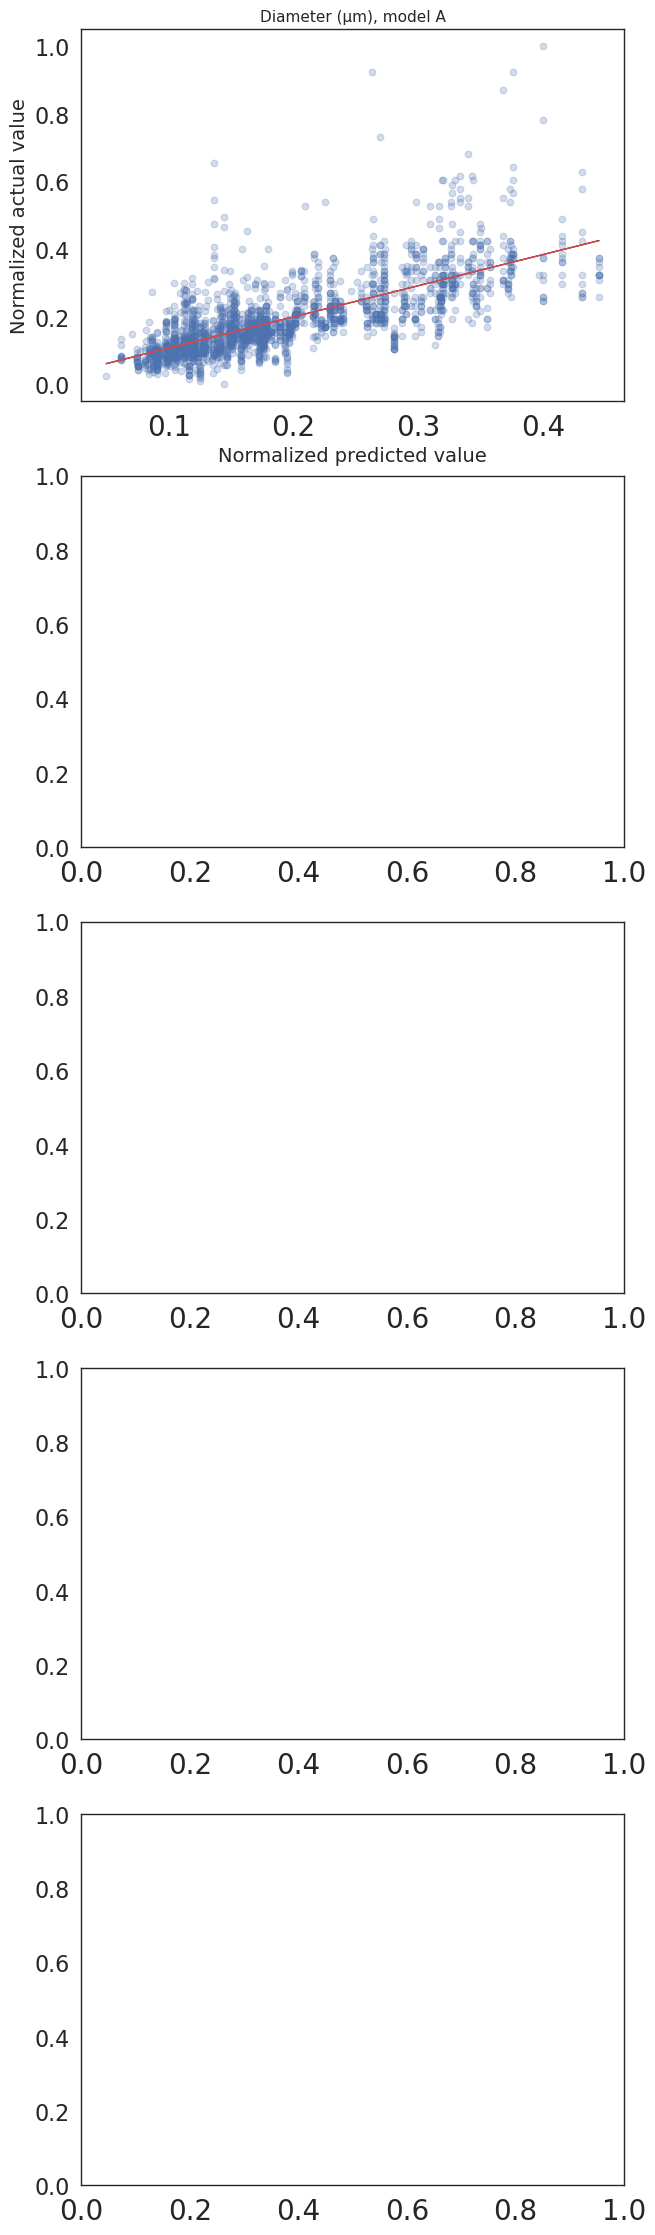

In [31]:
for k in 'A', 'B':
    fig, axs = plt.subplots(5, 1)
    fig.set_figheight(28)
    fig.set_figwidth(7)
    for i in range(5):
        col = ds[k].target_columns[i]
        x = Y_pred_tot[k].to_numpy()[:,i]
        y = Y_true_tot.to_numpy()[:,i]
        z = np.polyfit(x, y, 1)
        y_hat = np.poly1d(z)(x)
        axs[i].set_title(f'{col}, model {k}')
        axs[i].set_xlabel('Normalized predicted value')
        axs[i].set_ylabel('Normalized actual value')
        axs[i].scatter(x, y, c='b', alpha=.25)
        axs[i].plot(x, y_hat, "r-", lw=1)
        text = r"$y={:0.3f}\;x+{:0.3f}$".format(z[0], z[1]) + "\n" + r"$R^2 = {:0.3f}$".format(metrics_mean[k].loc['R2', col])
        axs[i].text(0.05, 0.95, text, transform=axs[i].transAxes,
        fontsize=14, verticalalignment='top')
    fig.savefig(f'../figures/scatter_{k}.png')
    plt.show()

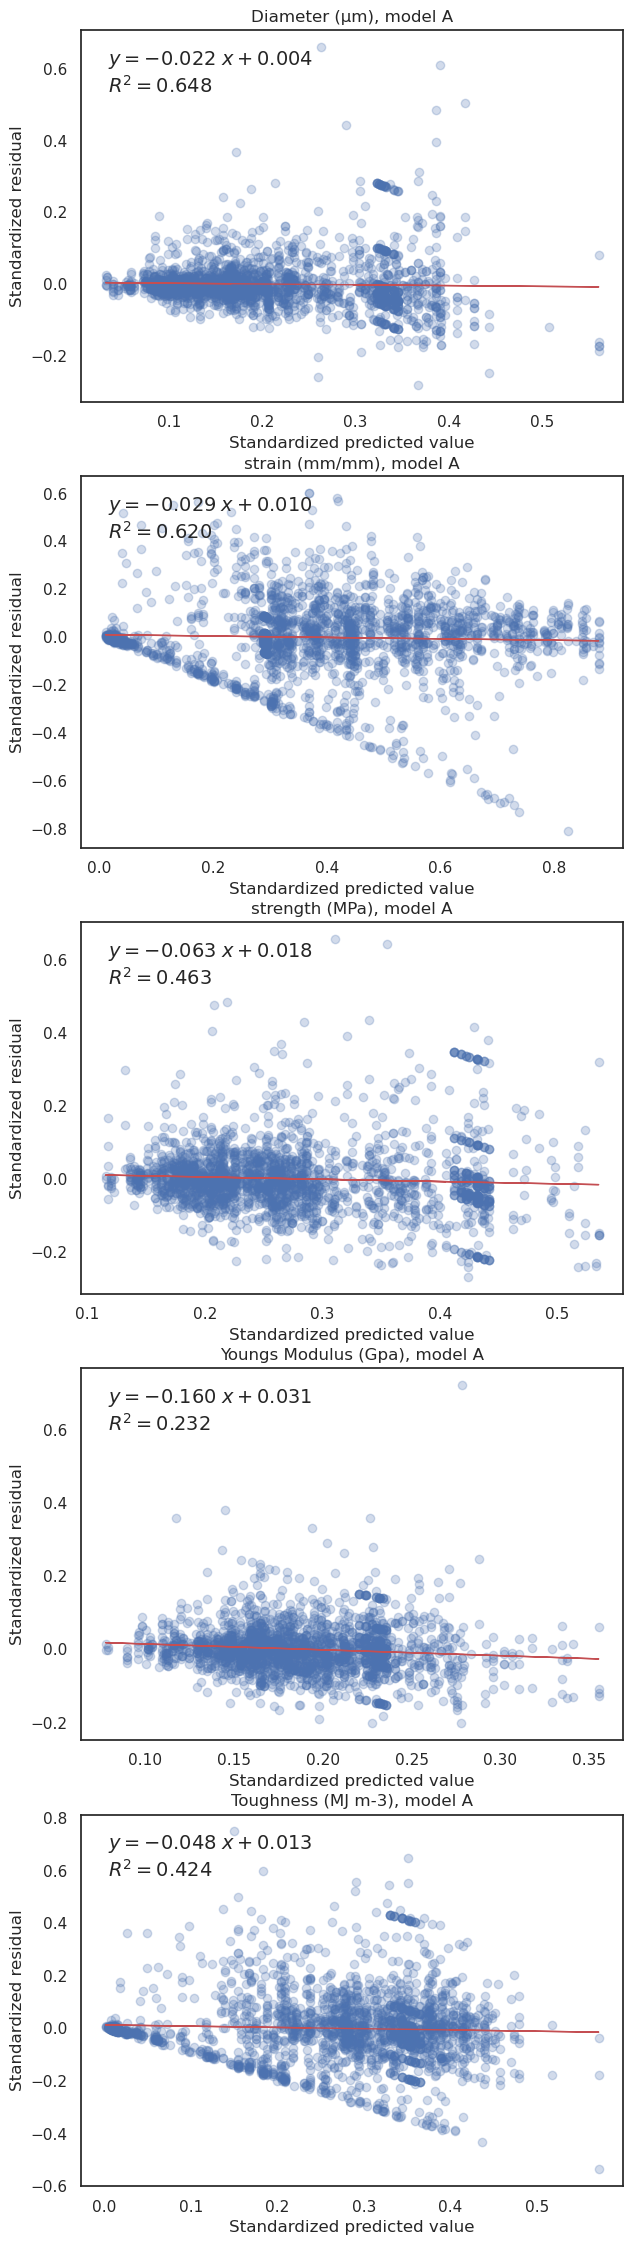

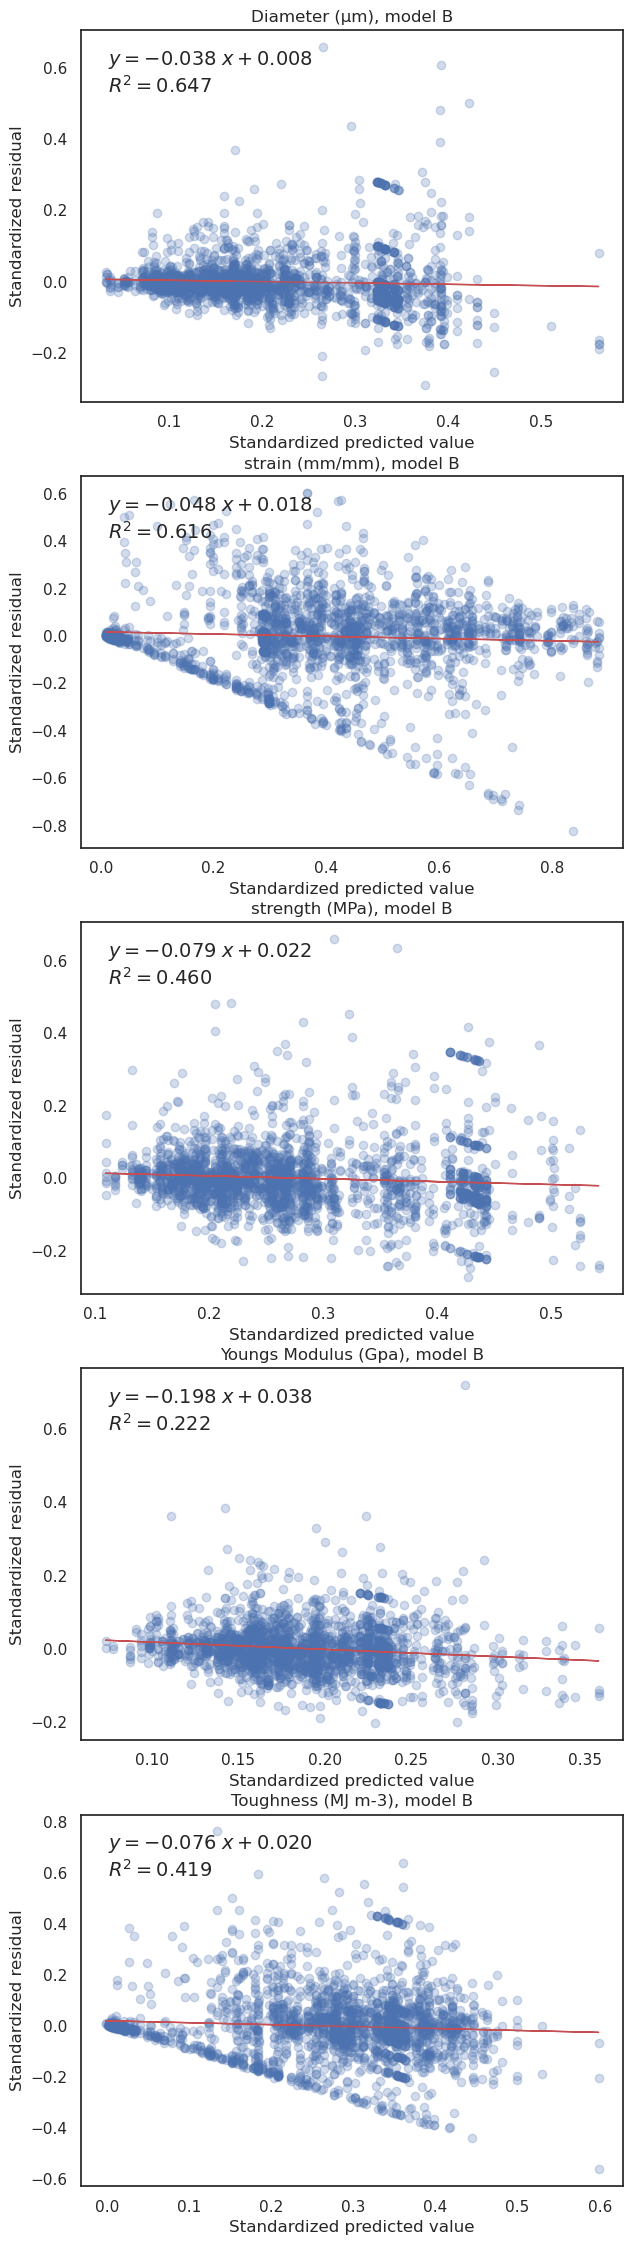

In [ ]:
for k in 'A', 'B':
    fig, axs = plt.subplots(5, 1)
    fig.set_figheight(28)
    fig.set_figwidth(7)
    for i in range(5):
        col = ds[k].target_columns[i]
        x = Y_pred_tot[k].to_numpy()[:,i]
        y = Y_true_tot.to_numpy()[:,i] - Y_pred_tot[k].to_numpy()[:,i]
        z = np.polyfit(x, y, 1)
        y_hat = np.poly1d(z)(x)
        axs[i].set_title(f'{col}, model {k}')
        axs[i].set_xlabel('Normalized predicted value')
        axs[i].set_ylabel('Normalized residual')
        axs[i].scatter(x, y, c='b', alpha=.25)
        axs[i].plot(x, y_hat, "r-", lw=1)
        text = r"$y={:0.3f}\;x+{:0.3f}$".format(z[0], z[1]) + "\n" + r"$R^2 = {:0.3f}$".format(metrics_mean[k].loc['R2', col])
        axs[i].text(0.05, 0.95, text, transform=axs[i].transAxes,
        fontsize=14, verticalalignment='top')
    fig.savefig(f'../figures/residual_{k}.png')
    plt.show()